In [2]:
import os
from dotenv import load_dotenv
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [ ]:
# Загружаем переменные из .env файла
load_dotenv()

# Получаем значения переменных
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')
GROUP_ID = os.getenv('GROUP_ID')
API_VERSION = os.getenv('API_VERSION')

# Используем эти данные в проекте
print(f"Access Token: {ACCESS_TOKEN}")
print(f"Group ID: {GROUP_ID}")
print(f"API Version: {API_VERSION}")


In [13]:
url = 'https://api.vk.com/method/groups.getMembers'

# Узнаем общее количество подписчиков
params_count = {
    'group_id': GROUP_ID,
    'access_token': ACCESS_TOKEN,
    'v': API_VERSION
}
response = requests.get(url, params=params_count).json()

if 'response' in response:
    total_count = response['response']['count']
    print(f"Всего подписчиков: {total_count}")
else:
    print("Ошибка при получении количества подписчиков:", response)
    total_count = 0

Всего подписчиков: 96123


In [14]:
# Узнаем общее количество подписчиков
params_count = {
    'group_id': GROUP_ID,
    'access_token': ACCESS_TOKEN,
    'v': API_VERSION
}
response = requests.get(url, params=params_count).json()
total_count = response['response']['count']
print(f"Всего подписчиков: {total_count}")

# Цикл по всем offset (по 1000 за раз)
all_users = []

for offset in range(0, total_count, 1000):
    params = {
        'group_id': GROUP_ID,
        'fields': 'sex,bdate,city,universities,relation,personal,followers_count,last_seen,status,has_photo',
        'access_token': ACCESS_TOKEN,
        'v': API_VERSION,
        'count': 1000,
        'offset': offset
    }

    response = requests.get(url, params=params).json()

    if 'response' in response:
        users = response['response']['items']
        all_users.extend(users)
        print(f"Собрано: {len(all_users)} пользователей")
    else:
        print(f"Ошибка на offset {offset}: {response}")
        break

    time.sleep(0.01)  # Пауза между запросами

# В DataFrame
df = pd.DataFrame(all_users)

Всего подписчиков: 96123
Собрано: 1000 пользователей
Собрано: 2000 пользователей
Собрано: 3000 пользователей
Собрано: 4000 пользователей
Собрано: 5000 пользователей
Собрано: 6000 пользователей
Собрано: 7000 пользователей
Собрано: 8000 пользователей
Собрано: 9000 пользователей
Собрано: 10000 пользователей
Собрано: 11000 пользователей
Собрано: 12000 пользователей
Собрано: 13000 пользователей
Собрано: 14000 пользователей
Собрано: 15000 пользователей
Собрано: 16000 пользователей
Собрано: 17000 пользователей
Собрано: 18000 пользователей
Собрано: 19000 пользователей
Собрано: 20000 пользователей
Собрано: 21000 пользователей
Собрано: 22000 пользователей
Собрано: 23000 пользователей
Собрано: 24000 пользователей
Собрано: 25000 пользователей
Собрано: 26000 пользователей
Собрано: 27000 пользователей
Собрано: 28000 пользователей
Собрано: 29000 пользователей
Собрано: 30000 пользователей
Собрано: 31000 пользователей
Собрано: 32000 пользователей
Собрано: 33000 пользователей
Собрано: 34000 пользователе

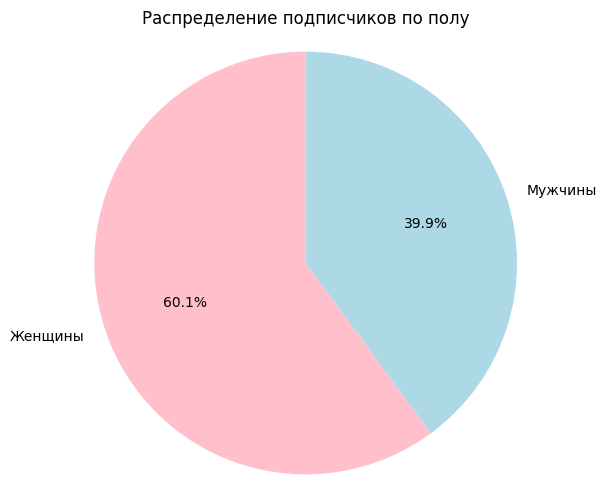

In [22]:
# Фильтруем только пол 1 и 2
df_sex = df[df['sex'].isin([1, 2])]

# Считаем
sex_counts = df_sex['sex'].value_counts().sort_index()

# Подписи
labels = ['Женщины', 'Мужчины']

# Круговая диаграмма
plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title('Распределение подписчиков по полу')
plt.axis('equal')
plt.show()


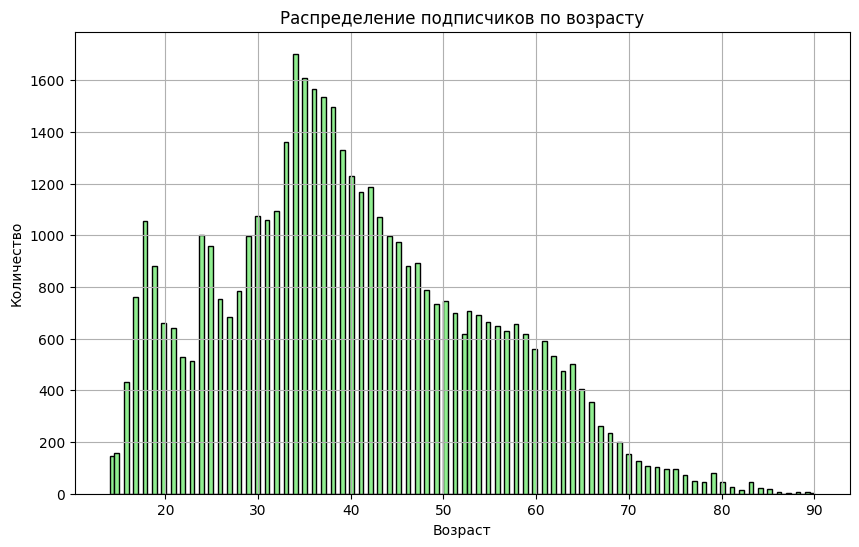

In [36]:
# Фильтруем только пользователей с полной датой рождения
df_bdate = df[df['bdate'].notnull()]
df_bdate = df_bdate[df_bdate['bdate'].str.count(r'\.') == 2]  # полные даты

# Вычислим возраст
def calculate_age(bdate_str):
    day, month, year = map(int, bdate_str.split('.'))
    today = datetime.datetime.today()
    age = today.year - year - ((today.month, today.day) < (month, day))
    return age

df_bdate['age'] = df_bdate['bdate'].apply(calculate_age)

# Оставим возраст 10-80 лет
df_age = df_bdate[(df_bdate['age'] >= 10) & (df_bdate['age'] <= 90)]

# Столбцовая диаграмма
plt.figure(figsize=(10, 6))
df_age['age'].plot(kind='hist', bins=150, color='lightgreen', edgecolor='black')
plt.title('Распределение подписчиков по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()


In [17]:
# Извлекаем только название города
df['city_title'] = df['city'].apply(lambda x: x['title'] if pd.notna(x) and isinstance(x, dict) else None)

In [18]:
# Безопасное извлечение: сначала проверка на NaN, затем на list, потом на ключи
df['university_name'] = df['universities'].apply(
    lambda x: (
        x[0].get('name') or x[0].get('chair_name')
    ) if isinstance(x, list) and len(x) > 0 else None
)


Топ вузов:
university
ТувГУ                            1321
МГУ                               140
ТывГУ                             111
СибУПК (ТФ)                        67
СИУ РАНХиГС (СибАГС)               67
ХГУ им. Катанова (бывш. АГПИ)      62
БГСХА                              59
ВСГИК (бывш. ВСГАКИ)               55
КрасГАУ                            51
СибУПК                             47
Name: count, dtype: int64


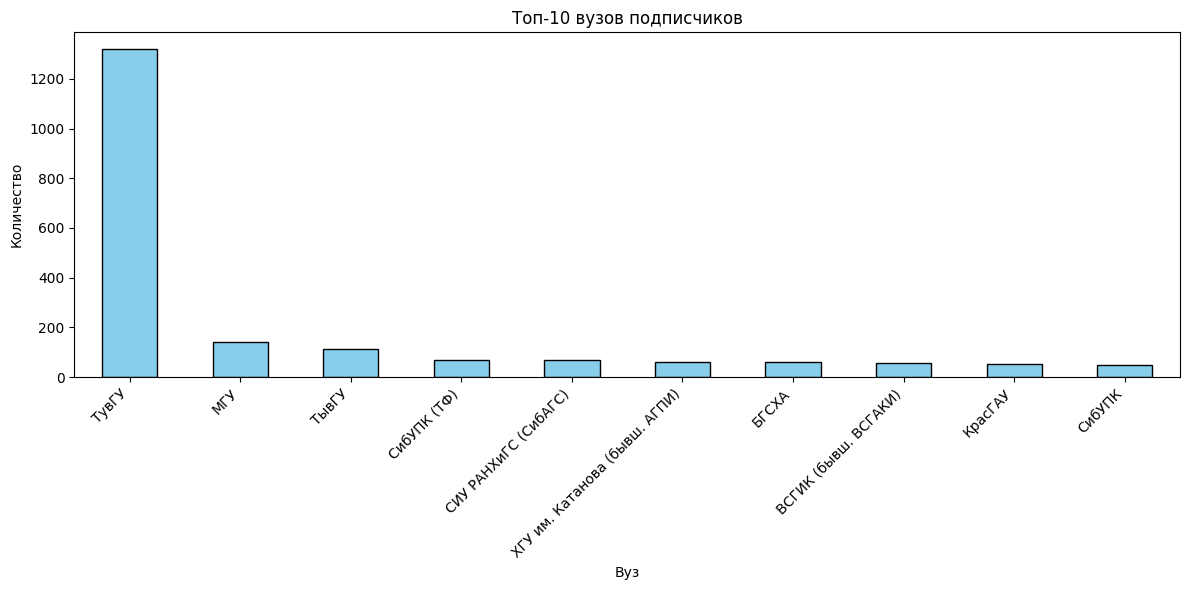

In [19]:
# Собираем все названия вузов из корректных списков
universities_list = []

for user in df['universities'].dropna():
    try:
        if isinstance(user, list):  # Проверяем, что это список
            for uni in user:
                name = uni.get('name') or uni.get('chair_name')  # Берём 'name' или 'chair_name'
                if name:
                    universities_list.append(name)
    except Exception as e:
        continue  # Пропускаем ошибки

# В DataFrame и считаем
df_uni = pd.DataFrame(universities_list, columns=['university'])
top_unis = df_uni['university'].value_counts().head(10)

# Проверим, есть ли что-то для построения
print("Топ вузов:")
print(top_unis)

# Строим график только если есть данные
if not top_unis.empty:
    plt.figure(figsize=(12, 6))
    top_unis.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Топ-10 вузов подписчиков')
    plt.xlabel('Вуз')
    plt.ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных о вузах для визуализации.")


In [20]:
df.groupby('deactivated')['first_name'].count()

deactivated
banned      5074
deleted    12094
Name: first_name, dtype: int64

In [24]:
df['sex'].value_counts()

sex
1    57740
2    38348
0       34
Name: count, dtype: int64

In [44]:
df.sort_values(ascending=False, by=['followers_count'])

,id,city,has_photo,last_seen,followers_count,relation,personal,universities,sex,first_name,last_name,can_access_closed,is_closed,status,bdate,deactivated,relation_partner,status_audio,city_title,university_name
14807,180881822,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 2, 'time': 1743271543}",47002.0,4.0,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 49, 'education_form': 'Full-time', '...",2,Sholban,Kara-Ool,True,False,Личная страница,18.7.1966,NaN,NaN,NaN,Kyzyl,УрГУ
16254,193049642,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 7, 'time': 1743277025}",30507.0,0.0,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...",[],2,Gtrk,Tyva,True,False,Мы рады приветствовать вас на официальной стра...,29.8.1936,NaN,NaN,NaN,Kyzyl,None
37093,360104045,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 2, 'time': 1743245896}",30094.0,4.0,NaN,"[{'city': 73, 'education_form': 'Full-time', '...",2,Vladislav,Khovalyg,True,False,t.me/khovalyg_live\n\nРегистрация в перечне РК...,24.12.1967,NaN,NaN,NaN,Kyzyl,ИЕиГН СФУ (бывш. КрасГУ)
13679,170267964,"{'id': 76, 'title': 'Kyzyl'}",1,"{'platform': 2, 'time': 1743266247}",28389.0,4.0,"{'alcohol': 0, 'inspired_by': '', 'langs': ['Р...","[{'city': 76, 'education_form': 'Full-time', '...",1,Borbaana,Barzhay,True,False,89527522050,22.4,NaN,NaN,NaN,Kyzyl,ТФ ВСГИК (бывш. ВСГАКИ ТФ)
491,9595595,"{'id': 73, 'title': 'Krasnoyarsk'}",1,"{'platform': 7, 'time': 1743268457}",28070.0,6.0,"{'alcohol': 0, 'inspired_by': 'Грег Плит, Арно...",[],2,Ivan,Vladimirovich,True,False,,22.12.1988,NaN,NaN,NaN,Krasnoyarsk,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96110,1038050993,NaN,0,"{'platform': 4, 'time': 1743242410}",NaN,0.0,NaN,[],1,Shonchalay,Kyrgys,False,True,,17.1.1977,NaN,NaN,NaN,None,None
96114,1038324149,NaN,0,"{'platform': 4, 'time': 1743247922}",NaN,NaN,NaN,NaN,1,Arzhaana,Ondar,False,True,,2.6,NaN,NaN,NaN,None,None
96115,1038402531,NaN,0,"{'platform': 4, 'time': 1743277268}",NaN,NaN,NaN,NaN,2,Tayny,Sledstvie,False,True,,19.1.1999,NaN,NaN,NaN,None,None
96118,1038809006,NaN,1,"{'platform': 4, 'time': 1743147826}",NaN,NaN,NaN,NaN,1,Yana,Hyrly,False,True,,NaN,NaN,NaN,NaN,None,None


In [54]:
df.groupby('first_name')['relation'].count().sort_values(ascending=False)

first_name
Choduraa         355
Alexander        339
Svetlana         333
Mongush          320
Ayana            308
                ... 
A I R              0
A I K              0
4in4i              0
***shenneshka      0
'skdsh             0
Name: relation, Length: 11795, dtype: int64